In [61]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import datetime
from statsmodels.tsa.stattools import adfuller
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from prophet import Prophet
from prophet.diagnostics import cross_validation
from math import sqrt
from prophet.plot import add_changepoints_to_plot

# Data Loading and Overview

In [2]:
# Reading in the data
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/Steel_industry_data.csv', parse_dates=True) # change to your repository
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y %H:%M')

In [3]:
# Get sample head of the data
df.tail()

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type
35035,2018-12-31 23:00:00,3.85,4.86,0.00,0.0,62.10,100.00,82800,Weekday,Monday,Light_Load
35036,2018-12-31 23:15:00,3.74,3.74,0.00,0.0,70.71,100.00,83700,Weekday,Monday,Light_Load
35037,2018-12-31 23:30:00,3.78,3.17,0.07,0.0,76.62,99.98,84600,Weekday,Monday,Light_Load
35038,2018-12-31 23:45:00,3.78,3.06,0.11,0.0,77.72,99.96,85500,Weekday,Monday,Light_Load
35039,2018-12-31 00:00:00,3.67,3.02,0.07,0.0,77.22,99.98,0,Weekday,Monday,Light_Load


In [4]:
# Getting the column infor
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35040 entries, 0 to 35039
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   date                                  35040 non-null  datetime64[ns]
 1   Usage_kWh                             35040 non-null  float64       
 2   Lagging_Current_Reactive.Power_kVarh  35040 non-null  float64       
 3   Leading_Current_Reactive_Power_kVarh  35040 non-null  float64       
 4   CO2(tCO2)                             35040 non-null  float64       
 5   Lagging_Current_Power_Factor          35040 non-null  float64       
 6   Leading_Current_Power_Factor          35040 non-null  float64       
 7   NSM                                   35040 non-null  int64         
 8   WeekStatus                            35040 non-null  object        
 9   Day_of_week                           35040 non-null  object        
 10

In [5]:
# Check number of nulls
df.isna().sum()

date                                    0
Usage_kWh                               0
Lagging_Current_Reactive.Power_kVarh    0
Leading_Current_Reactive_Power_kVarh    0
CO2(tCO2)                               0
Lagging_Current_Power_Factor            0
Leading_Current_Power_Factor            0
NSM                                     0
WeekStatus                              0
Day_of_week                             0
Load_Type                               0
dtype: int64

In [6]:
# check how many duplicate rows are there
df.duplicated().sum()

0

In [7]:
 #Summary statistics of the datase
df.describe()

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM
count,35040,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000
mean,2018-07-02 11:52:30,27.386892,13.035384,3.870949,0.011524,80.578056,84.367870,42750.000000
min,2018-01-01 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2018-04-02 05:56:15,3.200000,2.300000,0.000000,0.000000,63.320000,99.700000,21375.000000
50%,2018-07-02 11:52:30,4.570000,5.000000,0.000000,0.000000,87.960000,100.000000,42750.000000
75%,2018-10-01 17:48:45,51.237500,22.640000,2.090000,0.020000,99.022500,100.000000,64125.000000
max,2018-12-31 23:45:00,157.180000,96.910000,27.760000,0.070000,100.000000,100.000000,85500.000000
std,NaN,33.444380,16.306000,7.424463,0.016151,18.921322,30.456535,24940.534317


In [8]:
# Categorical Unique Values for Status of Day
df['WeekStatus'].unique()

array(['Weekday', 'Weekend'], dtype=object)

In [9]:
# Categorical Status for Day of Week
df['Day_of_week'].unique()

array(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday',
       'Sunday'], dtype=object)

In [10]:
# Categorical Status for Load Type
df['Load_Type'].unique()

array(['Light_Load', 'Medium_Load', 'Maximum_Load'], dtype=object)

In [11]:
# Value Counts of Load Type
df['Load_Type'].value_counts()

Load_Type
Light_Load      18072
Medium_Load      9696
Maximum_Load     7272
Name: count, dtype: int64

In [39]:
# Getting the day of each date
df['day'] = pd.to_datetime(df['date']).dt.date

In [40]:
# Categorically Encode the Categorical Variables
df_encoded = pd.get_dummies(df, columns=['WeekStatus', 'Day_of_week', 'Load_Type'], dtype='int')

In [13]:
# Checking new info
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35040 entries, 0 to 35039
Data columns (total 20 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   date                                  35040 non-null  datetime64[ns]
 1   Usage_kWh                             35040 non-null  float64       
 2   Lagging_Current_Reactive.Power_kVarh  35040 non-null  float64       
 3   Leading_Current_Reactive_Power_kVarh  35040 non-null  float64       
 4   CO2(tCO2)                             35040 non-null  float64       
 5   Lagging_Current_Power_Factor          35040 non-null  float64       
 6   Leading_Current_Power_Factor          35040 non-null  float64       
 7   NSM                                   35040 non-null  int64         
 8   WeekStatus_Weekday                    35040 non-null  int64         
 9   WeekStatus_Weekend                    35040 non-null  int64         
 10

# Visualizations

## Time Series of Usage over Time (Unchanged)

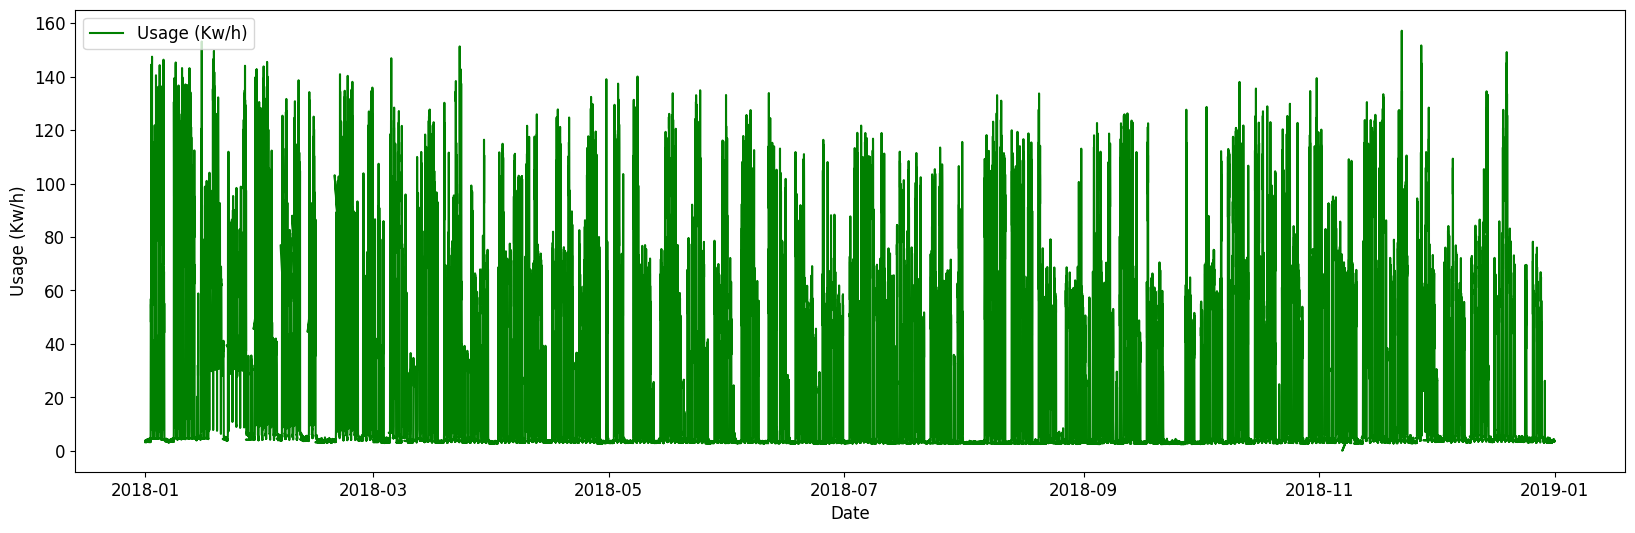

In [14]:
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(20, 6))

ax.plot(df.date, df.Usage_kWh, color='green', label='Usage (Kw/h)')
ax.set_xlabel('Date')
ax.set_ylabel('Usage (Kw/h)')
ax.legend(loc='upper left')
plt.show()

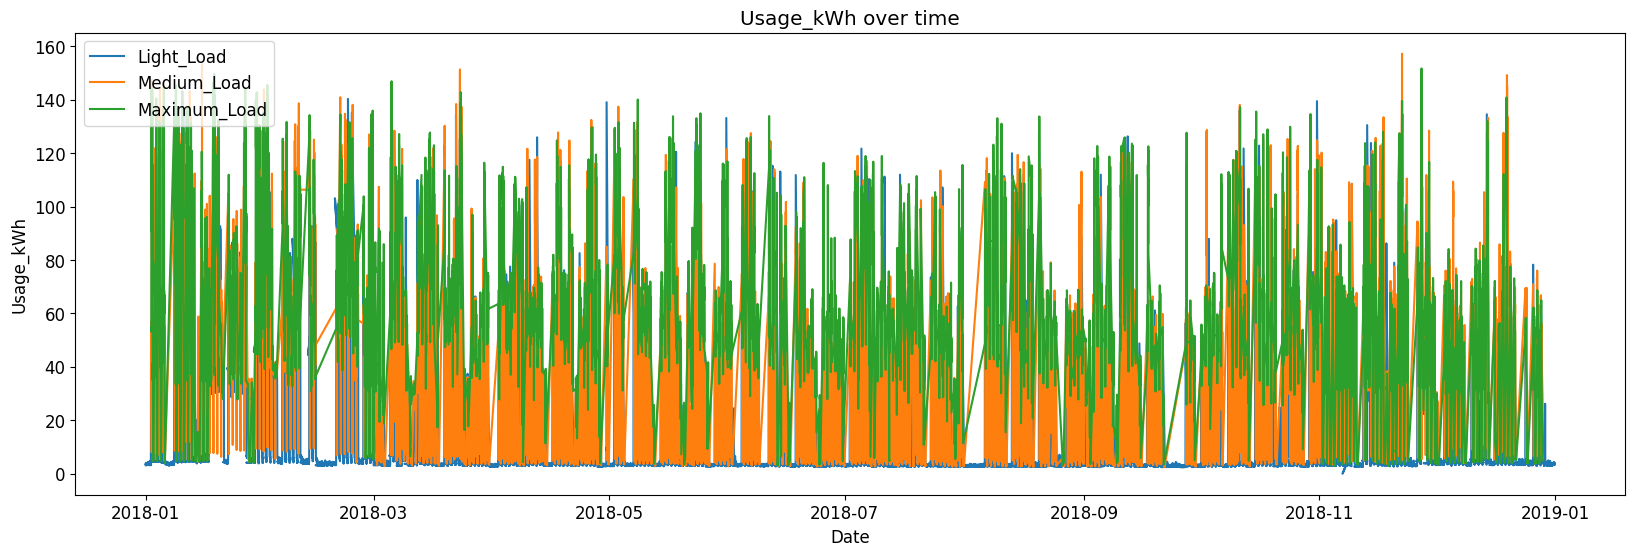

In [15]:
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(20, 6))

# Iterate over unique load types and plot each separately
for load_type in df['Load_Type'].unique():
    df_subset = df[df['Load_Type'] == load_type]
    ax.plot(df_subset.date, df_subset.Usage_kWh, label=load_type)  # Use label for legend

ax.set_xlabel('Date')
ax.set_ylabel('Usage_kWh')
ax.set_title('Usage_kWh over time')
ax.legend(loc='upper left')  # Show legend
plt.show()

## Time Series of Daily Average Usage

In [17]:
# Convert 'Usage_kWh' column to numeric, handling non-numeric values
df['Usage_kWh'] = pd.to_numeric(df['Usage_kWh'], errors='coerce')

# Calculate the mean of numerical columns after grouping by 'day'
dfnew_mean = df.drop(['date'], axis=1).groupby(['day', 'Day_of_week', 'WeekStatus']).mean(numeric_only=True)
dfnew_mean.reset_index(inplace=True)
dfnew_mean.set_index('day', inplace=True)

# Calculate the maximum of numerical columns after grouping by 'day'
dfnew_max = df.drop(['date'], axis=1).groupby(['day', 'Day_of_week', 'WeekStatus']).max(numeric_only=True)
dfnew_max.reset_index(inplace=True)
dfnew_max.set_index('day', inplace=True)

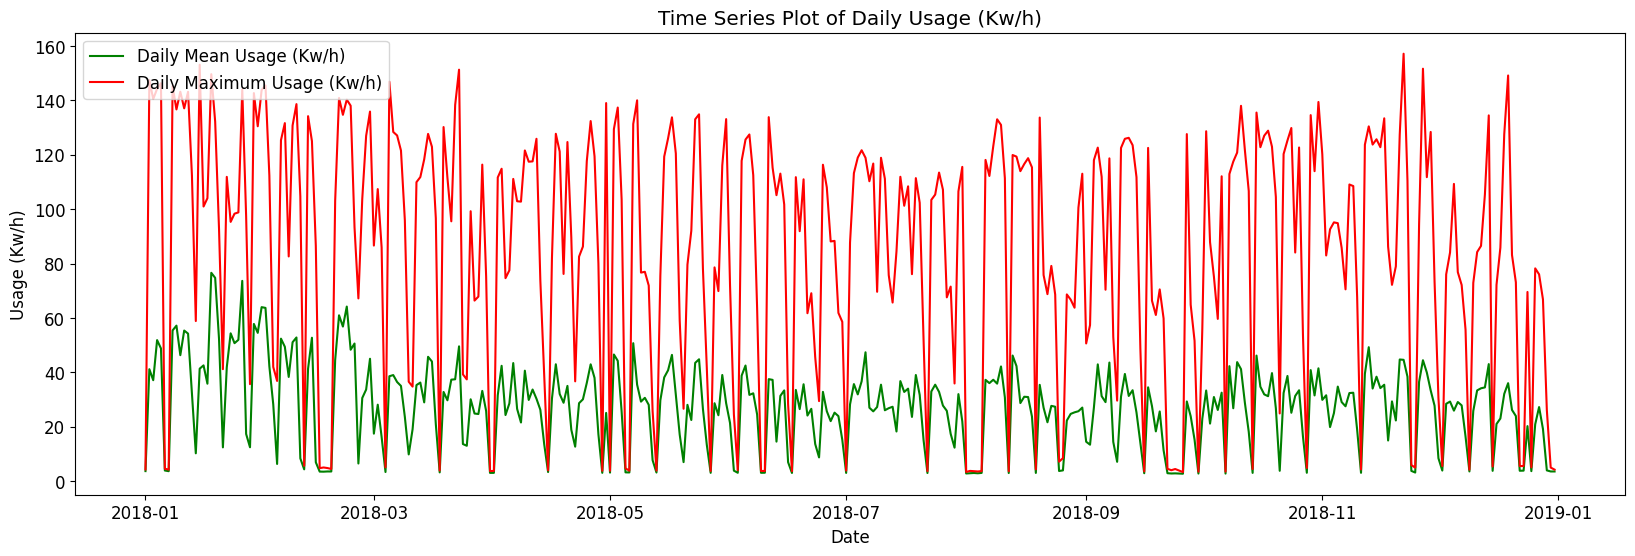

In [18]:
#see the TS plot

plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(20, 6), sharex=False)

ax.plot(dfnew_mean.Usage_kWh, color='green', label='Daily Mean Usage (Kw/h)')
ax.plot(dfnew_max.Usage_kWh, color='red', label='Daily Maximum Usage (Kw/h)')
ax.set_xlabel('Date')
ax.set_ylabel('Usage (Kw/h)')
ax.set_title('Time Series Plot of Daily Usage (Kw/h)')
ax.legend(loc='upper left')
plt.show()

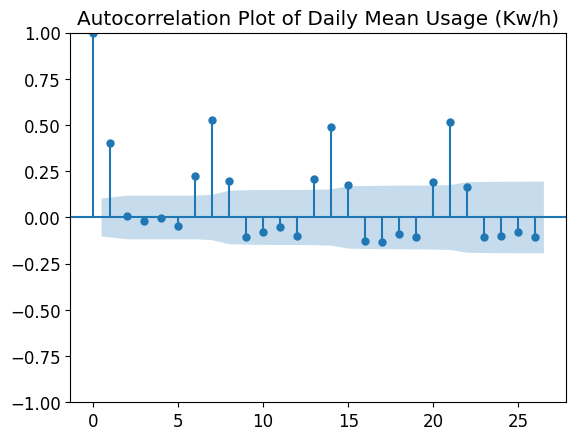

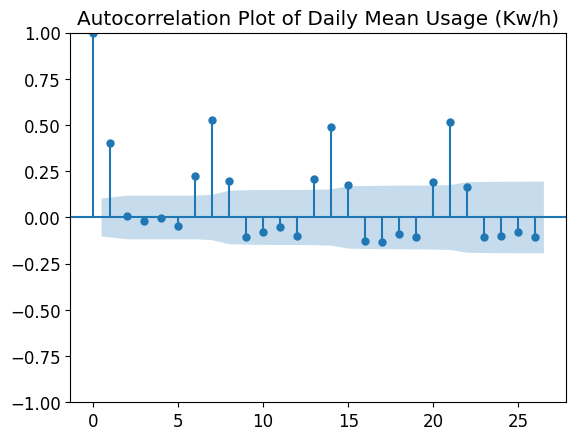

In [19]:
# ACF plot for Mean
plot_acf(dfnew_mean.Usage_kWh.squeeze(), title = "Autocorrelation Plot of Daily Mean Usage (Kw/h)")

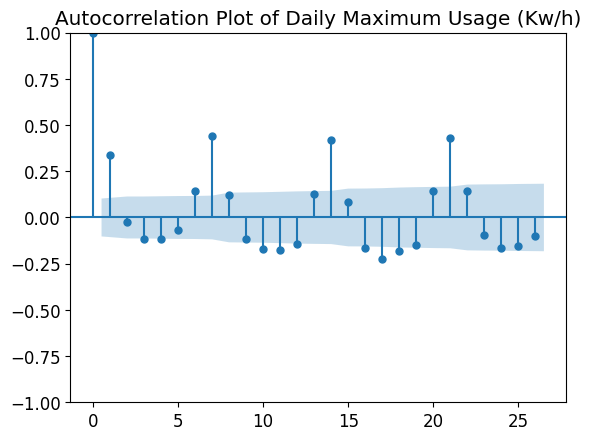

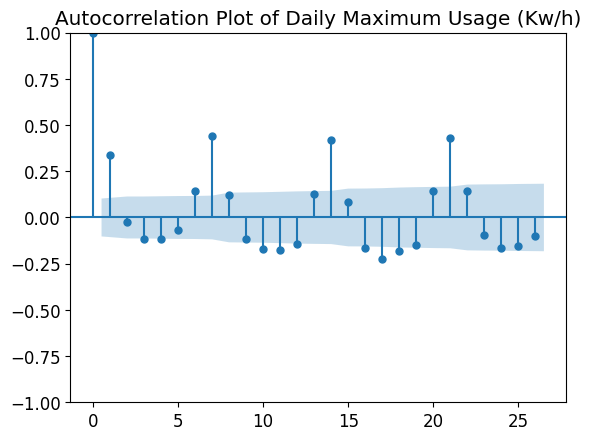

In [20]:
# ACF plot for Max
plot_acf(dfnew_max.Usage_kWh.squeeze(), title = "Autocorrelation Plot of Daily Maximum Usage (Kw/h)")

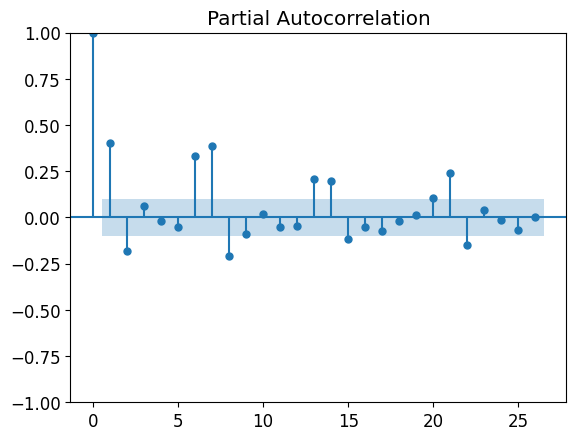

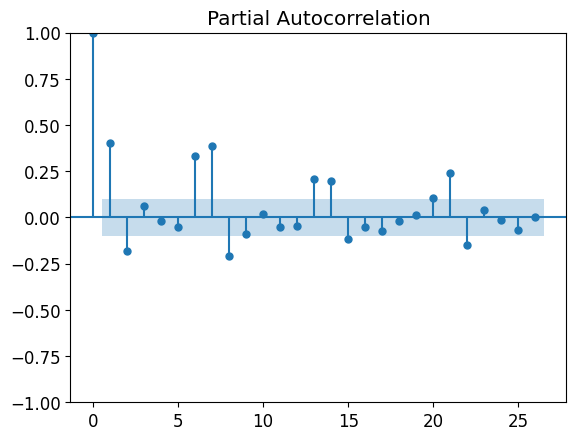

In [21]:
plot_pacf(dfnew_mean.Usage_kWh)

In [22]:
# Statistical Testing for Stationary for Mean
result = adfuller(dfnew_mean['Usage_kWh'].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -2.854991
p-value: 0.050838


In [23]:
# Statistical Testing for Stationary for Maximum
result = adfuller(dfnew_max['Usage_kWh'].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -4.223297
p-value: 0.000602


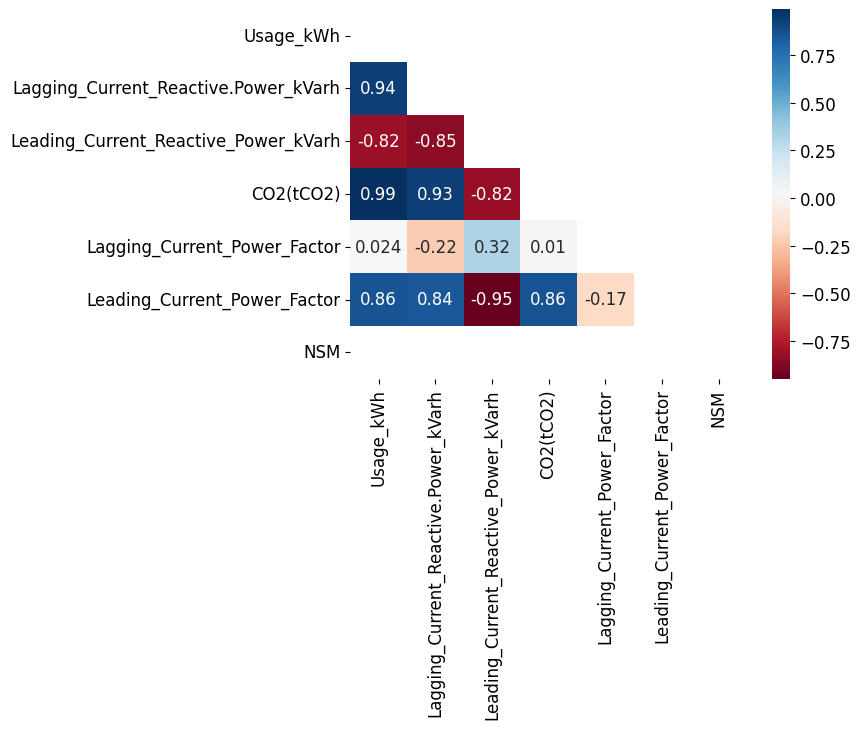

In [24]:
# Select only the numeric columns before calculating correlations
numeric_df = dfnew_mean.select_dtypes(include=['number'])
corr = numeric_df.corr()

# plot the correlation matrix and show labels for correlation values
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, annot=True, mask=mask, cmap='RdBu')

# show large plot
# plt.rcParams['figure.figsize'] = [40, 40]
plt.show()

## Time Series for Differenced Data

In [25]:
dfnew_copy = dfnew_mean.select_dtypes(include=['number']).copy()
D1_mean = dfnew_copy.diff()

dfnew_copy = dfnew_max.select_dtypes(include=['number']).copy()
D1_max = dfnew_copy.diff()

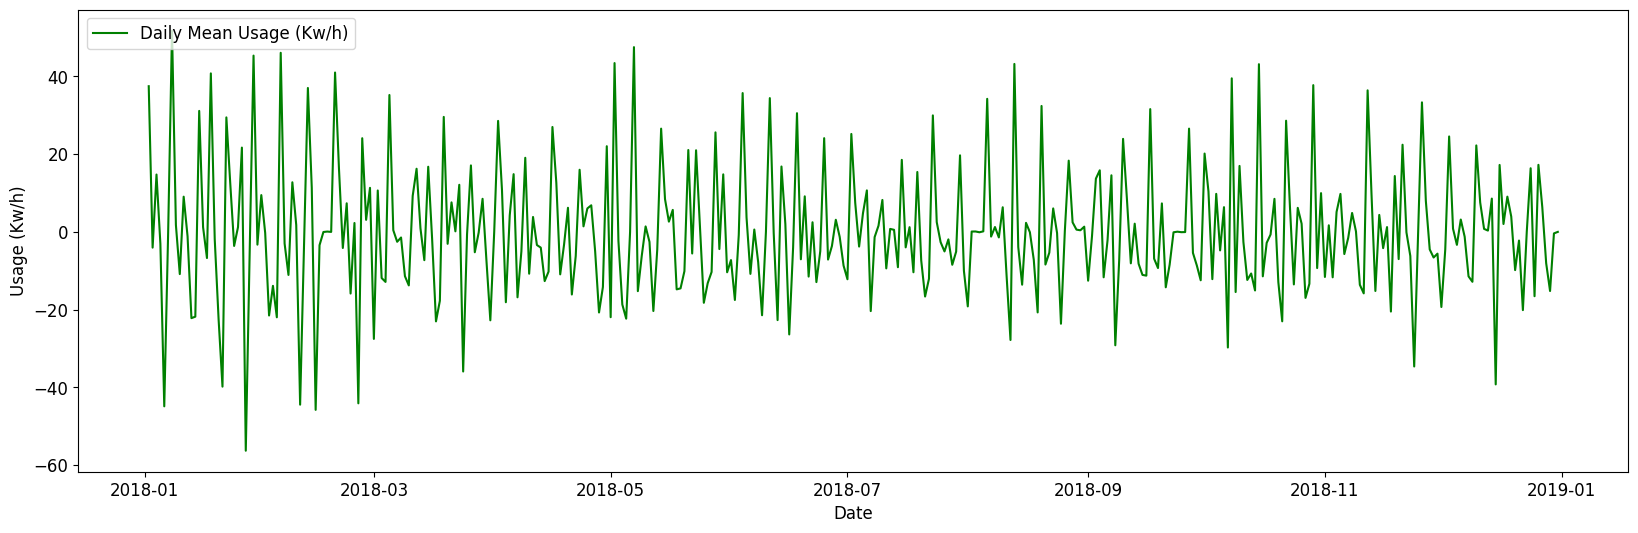

In [26]:
#see the TS plot

plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(20, 6))

ax.plot(D1_mean.Usage_kWh, color='green', label='Daily Mean Usage (Kw/h)')
# ax.plot(D1_max.Usage_kWh, color='red', label='Daily Maximum Usage (Kw/h)')
ax.set_xlabel('Date')
ax.set_ylabel('Usage (Kw/h)')
ax.legend(loc='upper left')
plt.show()

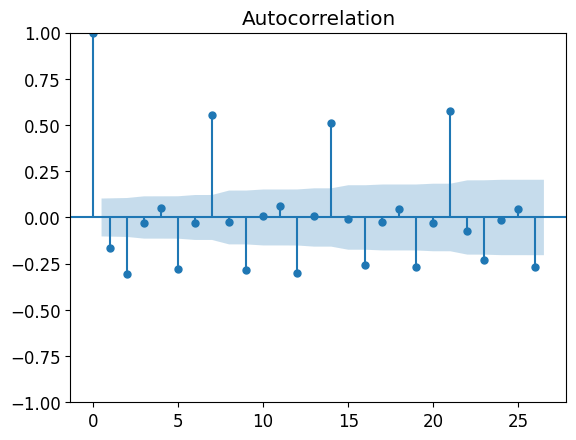

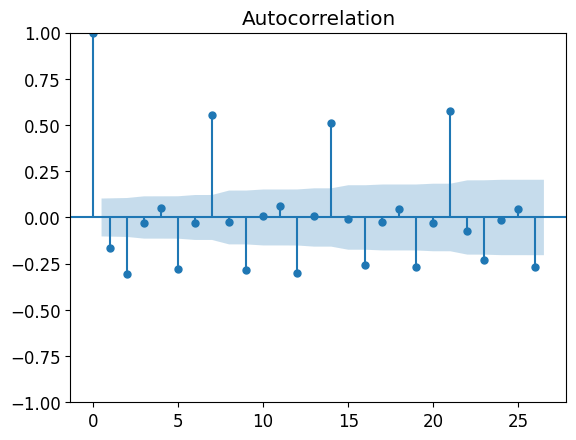

In [27]:
# ACF plot
plot_acf(D1_mean.Usage_kWh, missing='drop')

In [28]:
# Statistical Testing for Stationary
result = adfuller(D1_mean['Usage_kWh'].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -8.167896
p-value: 0.000000


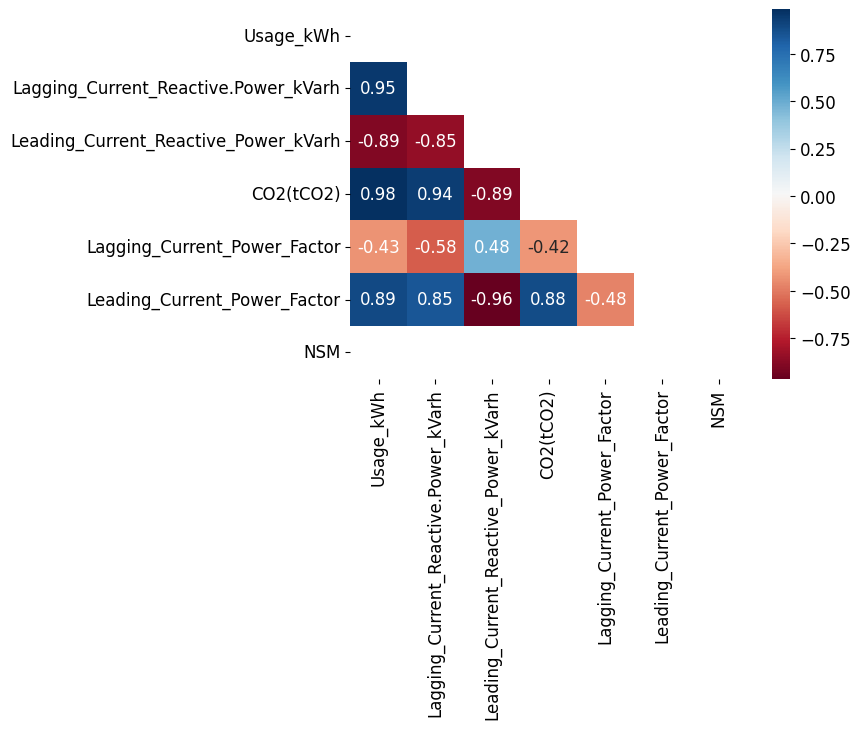

In [29]:
# Select only the numeric columns before calculating correlations
numeric_df = D1_mean.select_dtypes(include=['number'])
corr = numeric_df.corr()

# plot the correlation matrix and show labels for correlation values
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, annot=True, mask=mask, cmap='RdBu')

# show large plot
# plt.rcParams['figure.figsize'] = [40, 40]
plt.show()

## Boxplots per day


<ipython-input-30-2a385730a9ba>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Day_of_week", y="Usage_kWh", data=dfnew_max, ax=ax, palette="Set3", legend=False)


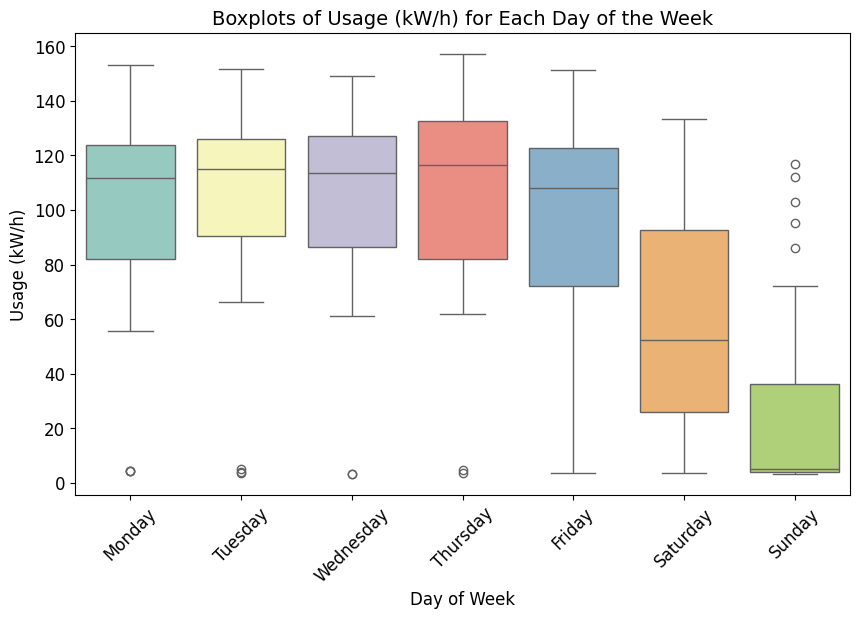

In [30]:
# Create a figure with a single subplot
fig, ax = plt.subplots(figsize=(10, 6))

# Create boxplots for each day of the week
sns.boxplot(x="Day_of_week", y="Usage_kWh", data=dfnew_max, ax=ax, palette="Set3", legend=False)

# Set labels and title
ax.set_xlabel("Day of Week", fontsize=12)
ax.set_ylabel("Usage (kW/h)", fontsize=12)
ax.set_title("Boxplots of Usage (kW/h) for Each Day of the Week", fontsize=14)

# Rotate x-axis labels for better readability
ax.tick_params(axis="x", rotation=45)

# Show the plot
plt.show()

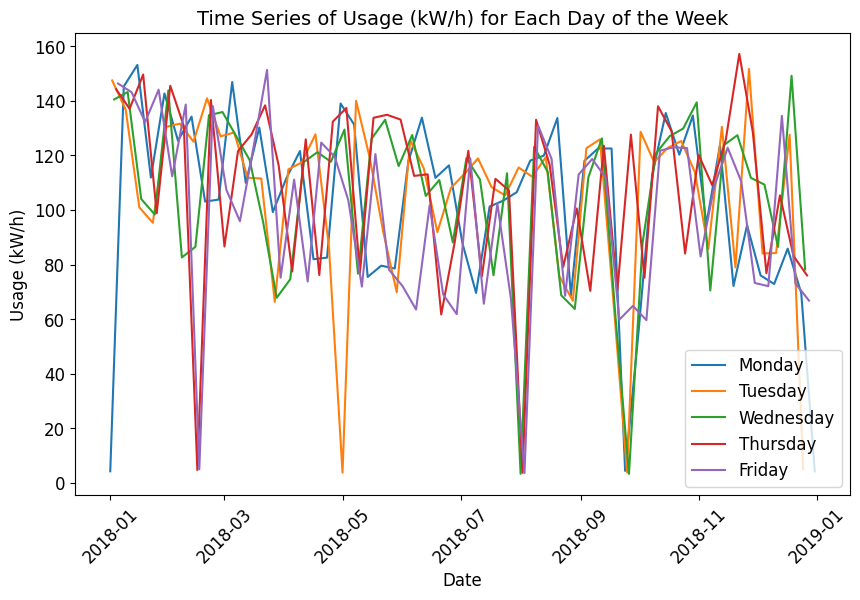

In [31]:
# Create a new figure with a single subplot
fig, ax = plt.subplots(figsize=(10, 6))

# Iterate over each day of the week and plot the time series
for day in dfnew_max['Day_of_week'].unique():
  if day != "Saturday" and day != "Sunday":
    df_day = dfnew_max[dfnew_max['Day_of_week'] == day]
    ax.plot(df_day.index, df_day['Usage_kWh'], label=day)

# Set labels and title
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Usage (kW/h)", fontsize=12)
ax.set_title("Time Series of Usage (kW/h) for Each Day of the Week", fontsize=14)

# Rotate x-axis labels for better readability
ax.tick_params(axis="x", rotation=45)

# Add legend and show the plot
ax.legend()
plt.show()


## Time Series of Time of day vs Usage

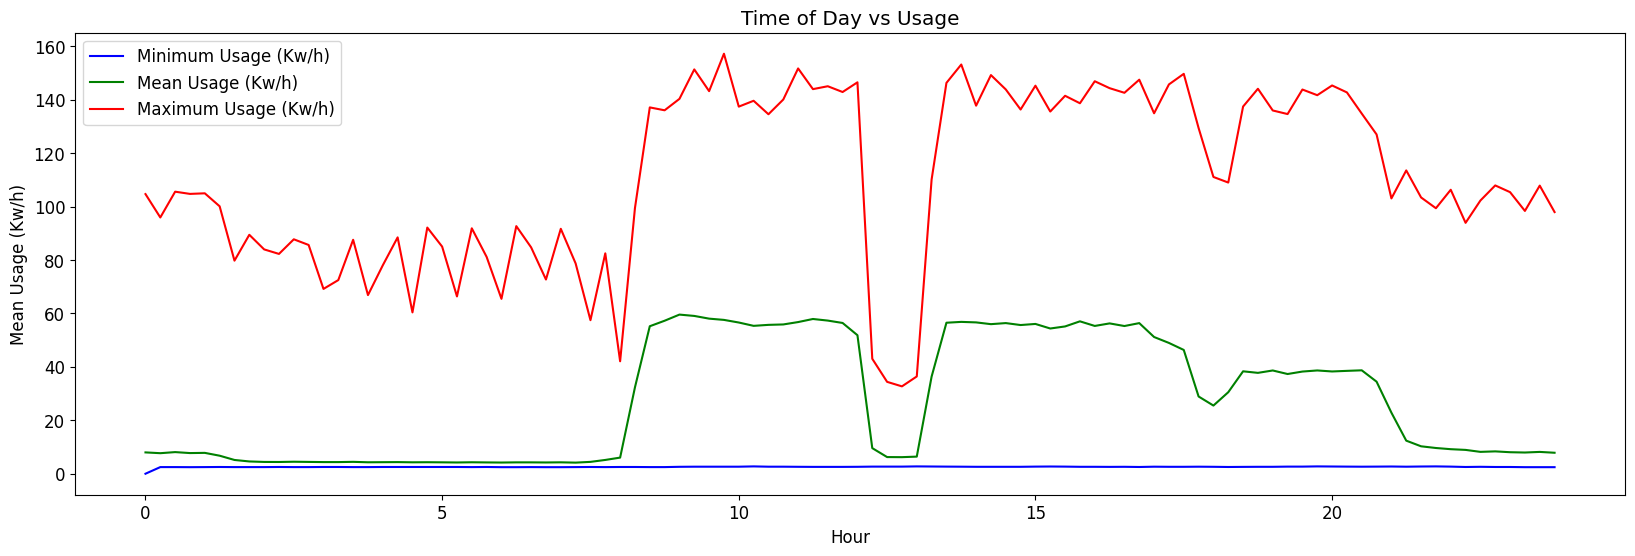

In [32]:
df_t = df.copy()
# Convert to hours and extract the hour component
df_t['time_of_day_hour'] = df_t['NSM'] / 3600
df_time_min = df_t.groupby(['time_of_day_hour']).min(['Usage_kWh'])
# df_time_med = df_t.groupby(['time_of_day_hour']).median(['Usage_kWh'])
df_time_mea = df_t.groupby(['time_of_day_hour']).mean(['Usage_kWh'])
df_time_max = df_t.groupby(['time_of_day_hour']).max(['Usage_kWh'])

#see the TS plot

plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(20, 6))

ax.plot(df_time_min.Usage_kWh, color='blue', label='Minimum Usage (Kw/h)')
# ax.plot(df_time_med.Usage_kWh, color='black', label='Median Usage (Kw/h)')
ax.plot(df_time_mea.Usage_kWh, color='green', label='Mean Usage (Kw/h)')
ax.plot(df_time_max.Usage_kWh, color='red', label='Maximum Usage (Kw/h)')
ax.set_title('Time of Day vs Usage')
ax.set_xlabel('Hour')
ax.set_ylabel('Mean Usage (Kw/h)')
ax.legend(loc='upper left')
plt.show()

# Rotate x-axis labels for better readability
ax.tick_params(axis="x", rotation=45)

# Add legend and show the plot
ax.legend()
plt.show()

## Boxplot of Load Types

<ipython-input-33-c942a647320b>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Load_Type", y="Usage_kWh", data=df, ax=ax, palette="Set3", legend=False)


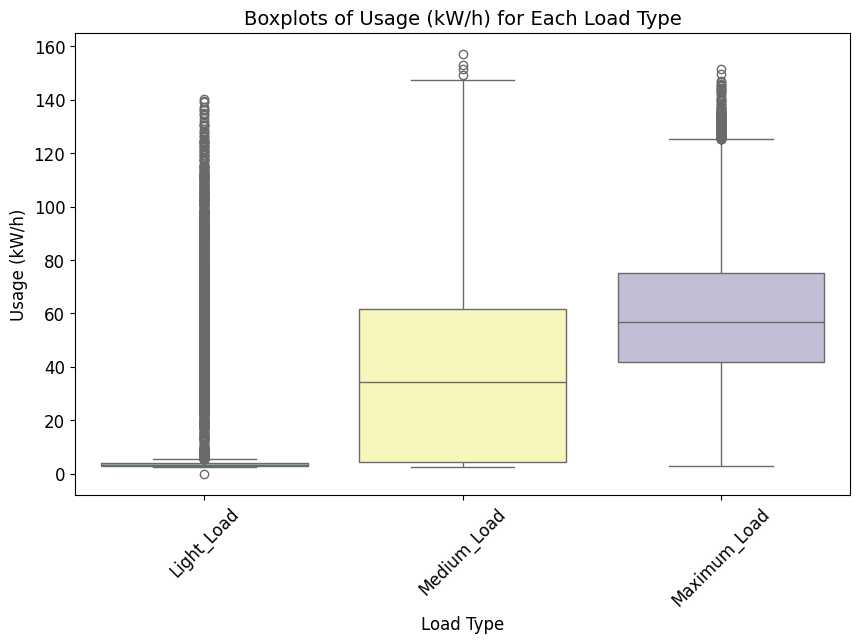

In [33]:
# df_load = df.drop(['date'], axis=1).groupby(['Load_Type']).mean(numeric_only=True)
# df_load.reset_index(inplace=True)

# Create a figure with a single subplot
fig, ax = plt.subplots(figsize=(10, 6))

# Create boxplots for each day of the week
sns.boxplot(x="Load_Type", y="Usage_kWh", data=df, ax=ax, palette="Set3", legend=False)

# Set labels and title
ax.set_xlabel("Load Type", fontsize=12)
ax.set_ylabel("Usage (kW/h)", fontsize=12)
ax.set_title("Boxplots of Usage (kW/h) for Each Load Type", fontsize=14)

# Rotate x-axis labels for better readability
ax.tick_params(axis="x", rotation=45)

# Show the plot
plt.show()

## Ratio of Load Types Plots

In [38]:
df_encoded.columns

Index(['date', 'Usage_kWh', 'Lagging_Current_Reactive.Power_kVarh',
       'Leading_Current_Reactive_Power_kVarh', 'CO2(tCO2)',
       'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor', 'NSM',
       'WeekStatus_Weekday', 'WeekStatus_Weekend', 'Day_of_week_Friday',
       'Day_of_week_Monday', 'Day_of_week_Saturday', 'Day_of_week_Sunday',
       'Day_of_week_Thursday', 'Day_of_week_Tuesday', 'Day_of_week_Wednesday',
       'Load_Type_Light_Load', 'Load_Type_Maximum_Load',
       'Load_Type_Medium_Load'],
      dtype='object')

In [46]:
df_ratios = df_encoded.groupby(['day']).agg({
    'Usage_kWh': 'mean',
    'Load_Type_Light_Load': 'sum',
    'Load_Type_Maximum_Load': 'sum',
    'Load_Type_Medium_Load': 'sum',
    # Add other features as needed
})

In [49]:
# Create the ratios
df_ratios['Light_Load_Ratio'] = (df_ratios['Load_Type_Light_Load'] / 96)*100
df_ratios['Medium_Load_Ratio'] = (df_ratios['Load_Type_Medium_Load'] / 96)*100
df_ratios['Maximum_Load_Ratio'] = (df_ratios['Load_Type_Maximum_Load'] / 96) * 100

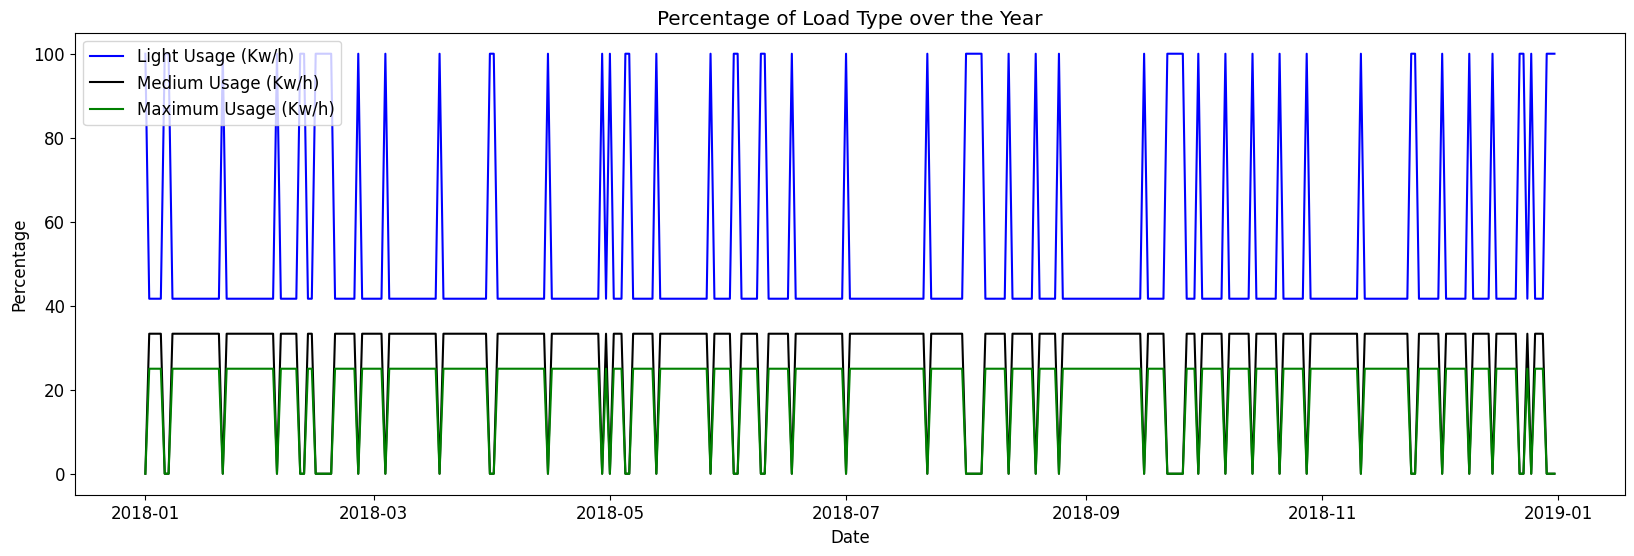

In [53]:
#see the TS plot

plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(20, 6))

ax.plot(df_ratios.Light_Load_Ratio, color='blue', label='Light Usage (Kw/h)')
ax.plot(df_ratios.Medium_Load_Ratio, color='black', label='Medium Usage (Kw/h)')
ax.plot(df_ratios.Maximum_Load_Ratio, color='green', label='Maximum Usage (Kw/h)')
ax.set_title('Percentage of Load Type over the Year')
ax.set_xlabel('Date')
ax.set_ylabel('Percentage')
ax.legend(loc='upper left')
plt.show()

# Rotate x-axis labels for better readability
ax.tick_params(axis="x", rotation=45)

# Add legend and show the plot
ax.legend()
plt.show()

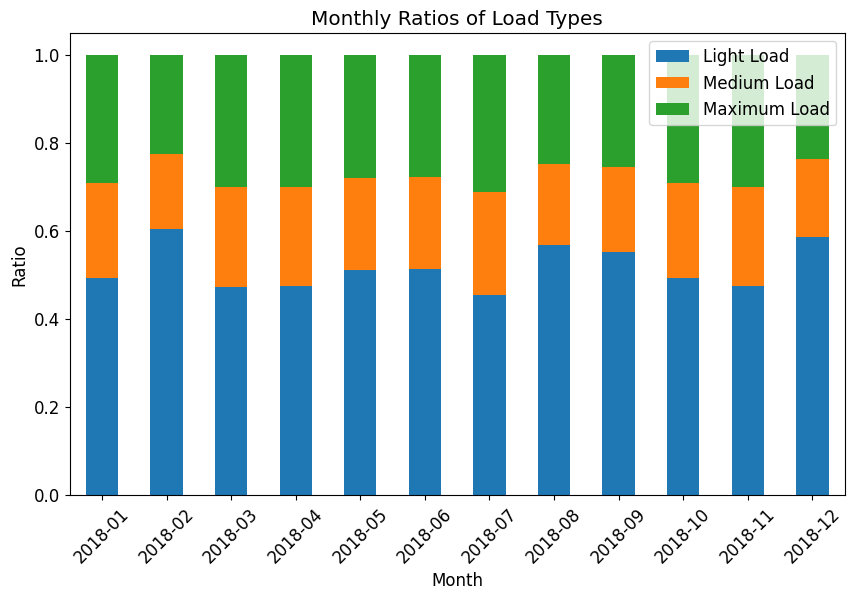

In [64]:
# Extract month from the 'date' column
df['month'] = df['date'].dt.to_period('M')

# Group by month and Load_Type and count occurrences
load_durations_monthly = df.groupby(['month', 'Load_Type'])['date'].count().unstack(fill_value=0)

# Calculate monthly ratios
monthly_ratios = load_durations_monthly.div(load_durations_monthly.sum(axis=1), axis=0)

# Plot monthly ratios
monthly_ratios.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Monthly Ratios of Load Types')
plt.xlabel('Month')
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.ylabel('Ratio')
plt.xticks(rotation=45)

# Customize Load_Type labels and order
load_type_labels = ['Light Load', 'Medium Load', 'Maximum Load']

# Assuming you have columns named 'Light_Load_Ratio', 'Medium_Load_Ratio', 'Maximum_Load_Ratio'
plt.legend(load_type_labels)
plt.show()

## Time Series of Co2

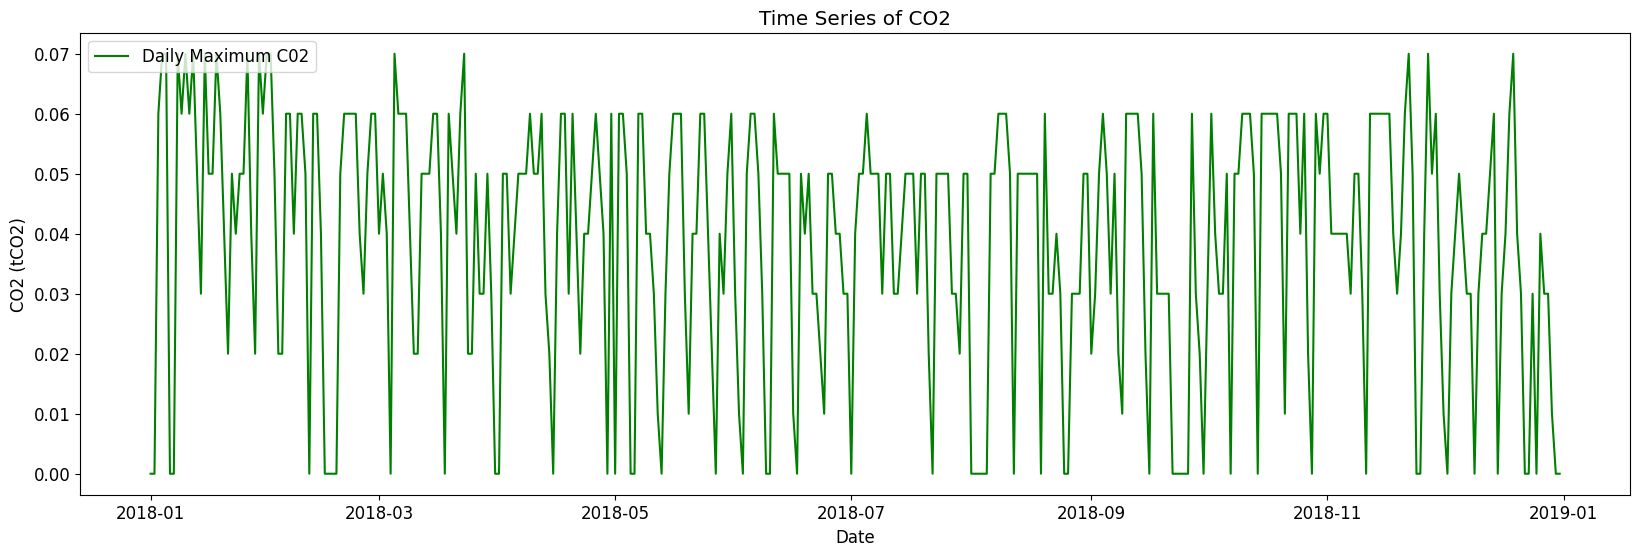

In [66]:
#see the TS plot
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(20, 6))

ax.plot(dfnew_max['CO2(tCO2)'], color='green', label='Daily Maximum C02')
ax.set_xlabel('Date')
ax.set_ylabel('CO2 (tCO2)')
ax.set_title('Time Series of CO2')
ax.legend(loc='upper left')
plt.show()

In [67]:
# Statistical Testing for Stationary for Mean
result = adfuller(dfnew_max['CO2(tCO2)'].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -4.196585
p-value: 0.000668


## Scatterplot between Max CO2 and Maximum Usage

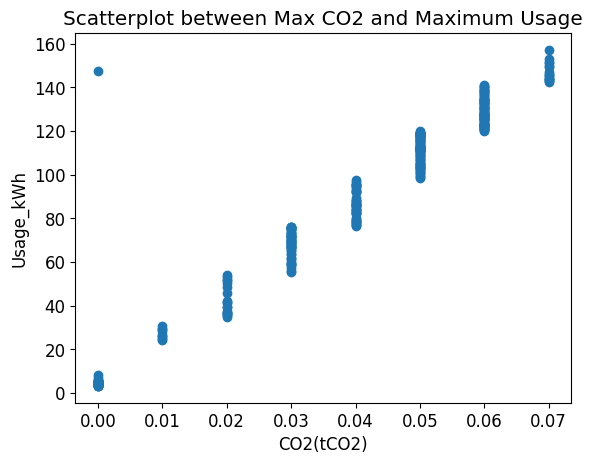

In [68]:
# scatterplot between CO2(tCO2) and Usage_kWh

plt.scatter(dfnew_max['CO2(tCO2)'], dfnew_max['Usage_kWh'])
plt.xlabel('CO2(tCO2)')
plt.ylabel('Usage_kWh')
plt.title('Scatterplot between Max CO2 and Maximum Usage')
plt.show()
